In [483]:
# %%
import os, sys, glob
from nilearn import image
from nilearn import plotting
import numpy as np
import pandas as pd
import h5py
from scipy import io
import matplotlib.pyplot as plt
import matplotlib.cm
cmap = matplotlib.cm.get_cmap('Reds')

%matplotlib inline

sys.path.append('/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages')
import rsatoolbox
import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
from rsatoolbox.model import ModelFixed
from rsatoolbox.inference import eval_fixed
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform
import math
import re

## essential function

In [484]:
def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))


def load_outcome(data_dir, sub, ses):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_outcome = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist:
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_04outcome = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns = ['trial_order', 'run_order'],
                            values=['event04_actual_angle']) #, aggfunc='first')
        seswise_04outcome.columns  = [ col[0]+'_'+str(col[1]) for col in seswise_04outcome.columns.values]
        seswise_04outcome = seswise_04outcome.reset_index()
        seswise_04outcome["condition"] = task + '_' + seswise_04outcome['param_cue_type'].astype(str) + '_' + seswise_04outcome["param_stimulus_type"]

        # reorder values
        seswise_04outcome['stim_order'] = seswise_04outcome['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        seswise_04outcome['cue_order'] = seswise_04outcome['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        ses_outcome = seswise_04outcome.sort_values(['cue_order','stim_order'])
        seswise_outcome = pd.concat([seswise_outcome, ses_outcome])
    return(seswise_outcome.reset_index(drop = True))


def load_fmri(singletrial_dir, sub, ses, run, atlas):
    from nilearn import datasets
    from nilearn.maskers import NiftiLabelsMasker
    dataset = datasets.fetch_atlas_schaefer_2018()
    atlas_filename = dataset.maps
    # labels = dataset.labels
    labels = np.insert(dataset.labels, 0, 'Background')
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                            memory='nilearn_cache', verbose=5)
    if atlas == True: 
        arr = np.empty((0, len(dataset['labels'])), int)  
    elif atlas == False:
        get_shape = glob.glob(os.path.join(
                singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
        get_shape_data = image.mean_img(image.concat_imgs(get_shape)).get_fdata().ravel()
        arr = np.empty((0, get_shape_data.shape[0]), int)
    # task_array = np.empty((18,0), int)
    
    for runtype in ['pain','cognitive', 'vicarious']:
        stim_H_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]

        
        # task_array = np.vstack((task_array, runwise_array))
        # arr = np.append(arr, runwise_array, axis=0)
        if atlas == True:
            stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H))
            stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H))
            stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H))
            stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L))
            stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L))
            stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L))
            runwise_array = masker.fit_transform(image.concat_imgs([stim_H_cue_H_mean,
                                                          stim_M_cue_H_mean,
                                                          stim_L_cue_H_mean,
                                                          stim_H_cue_L_mean,
                                                          stim_M_cue_L_mean,
                                                          stim_L_cue_L_mean
                                                           ])) # (trials, parcels)
            arr = np.concatenate((arr,runwise_array),axis=0)
    # np.vstack((arr, runwise_array))
        elif atlas == False:
            stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
            stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
            stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
            stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
            stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
            stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()
            runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
            arr = np.concatenate((arr,runwise_array),axis=0)
        mask = ~np.isnan(image.load_img(image.concat_imgs(stim_H_cue_H)).get_fdata())
    return(mask, arr, stim_flist)

def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [485]:
def get_unique_ses(sub_id, singletrial_dir):

    flist = glob.glob(os.path.join(singletrial_dir, sub_id, '*stimulus*trial-000_*.nii.gz'))
    # Initialize empty sets to store unique values of 'ses' and 'run'
    unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    for path in flist:
        # Extract 'ses-##' using regular expression
        ses_match = re.search(r'ses-(\d+)', path)
        if ses_match:
            unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r'run-(\d+)', path)
        if run_match:
            unique_run.add(run_match.group(0))
    # for run in sorted(unique_run):
    #     print(run)
    return unique_ses 

In [102]:
# load brain data
sub_list = ["sub-0003", "sub-0004", "sub-0005", "sub-0006", "sub-0009",    "sub-0010",    "sub-0018",    "sub-0025",    "sub-0029",    "sub-0031",    "sub-0032",    "sub-0033",    "sub-0034",    "sub-0036",    "sub-0037",    "sub-0038",    "sub-0039",    "sub-0043",    "sub-0044",    "sub-0046",    "sub-0050",    "sub-0051",    "sub-0052",    "sub-0053",    "sub-0055",    "sub-0056",    "sub-0057",    "sub-0058",    "sub-0060",    "sub-0061",    "sub-0062",    "sub-0065",    "sub-0073",
    "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090",    "sub-0091",    "sub-0092",    "sub-0093",    "sub-0094",    "sub-0095",    "sub-0098",    "sub-0099",    "sub-0100",    "sub-0101",    "sub-0102",    "sub-0104",    "sub-0105",    "sub-0106",    "sub-0107",    "sub-0109",    "sub-0115",    "sub-0116",    "sub-0122",    "sub-0124",    "sub-0126",    "sub-0127",    "sub-0128",    "sub-0129",    "sub-0130",    "sub-0132",    "sub-0133"]
sub_list = [ "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090"]
# sub_list = ['sub-0061']
ses_list = ['ses-01', 'ses-03', 'ses-04']  # , 'ses-04']
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        des = {'session': ses, 'subj': sub}
        # load behavioral data expectation rating
        expect_df = pd.DataFrame()
        expect_df = load_expect(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                                sub=sub, ses=ses)
        obs_des = {'pattern': np.array(expect_df.condition)}
        chn_des = {'ratings': np.array(
            ['ratings_' + str(x) for x in np.arange(4)])}
        beh_expect.append(rsd.Dataset(measurements=np.array(expect_df.filter(regex='event02_')),
                                      descriptors=des,
                                      obs_descriptors=obs_des,
                                      channel_descriptors=chn_des))
        # load behavioral data outcome rating
        outcome_df = load_outcome(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                                  sub=sub, ses=ses)
        beh_outcome.append(rsd.Dataset(measurements=np.array(outcome_df.filter(regex='event04_')),
                                       descriptors=des,
                                       obs_descriptors=obs_des,
                                       channel_descriptors=chn_des))
        # load fMRI data
        mask, fmri_df, stim_flist = load_fmri(singletrial_dir='/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/',
                                              sub=sub, ses=ses, run='*', atlas=True)
        obs_des = {'pattern': np.array(expect_df.condition)}
        rsd_data = rsd.Dataset(measurements=fmri_df,
                                     descriptors=des,
                                     obs_descriptors=obs_des,
                                     channel_descriptors={'roi': np.array(['roi_' + str(x) for x in np.arange(fmri_df.shape[1])])})
        fmri_data.append(rsd_data)
        rsd_data.save(f"{sub}_{ses}_RDM.hdf5")
# get mask
# get searchlight_RDM


[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f84aa04f460>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f84aa04f070>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memo

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [157]:
# load brain data
sub_list = ["sub-0003", "sub-0004", "sub-0005", "sub-0006", "sub-0009",    "sub-0010",    "sub-0018",    "sub-0025",    "sub-0029",    "sub-0031",    "sub-0032",    "sub-0033",    "sub-0034",    "sub-0036",    "sub-0037",    "sub-0038",    "sub-0039",    "sub-0043",    "sub-0044",    "sub-0046",    "sub-0050",    "sub-0051",    "sub-0052",    "sub-0053",    "sub-0055",    "sub-0056",    "sub-0057",    "sub-0058",    "sub-0060",    "sub-0061",    "sub-0062",    "sub-0065",    "sub-0073",
    "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090",    "sub-0091",    "sub-0092",    "sub-0093",    "sub-0094",    "sub-0095",    "sub-0098",    "sub-0099",    "sub-0100",    "sub-0101",    "sub-0102",    "sub-0104",    "sub-0105",    "sub-0106",    "sub-0107",    "sub-0109",    "sub-0115",    "sub-0116",    "sub-0122",    "sub-0124",    "sub-0126",    "sub-0127",    "sub-0128",    "sub-0129",    "sub-0130",    "sub-0132",    "sub-0133"]
sub_list = [ "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090"]
# sub_list = ['sub-0061']
sub_list = [ "sub-0080"]
ses_list = [ 'ses-04']  # , 'ses-04']'ses-01', 'ses-03',
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        des = {'session': ses, 'subj': sub}
        # load behavioral data expectation rating
        expect_df = pd.DataFrame()
        expect_df = load_expect(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                                sub=sub, ses=ses)
        # obs_des = {'pattern': np.array(expect_df.condition)}
        # chn_des = {'ratings': np.array(
        #     ['ratings_' + str(x) for x in np.arange(4)])}
        # beh_expect.append(rsd.Dataset(measurements=np.array(expect_df.filter(regex='event02_')),
        #                               descriptors=des,
        #                               obs_descriptors=obs_des,
        #                               channel_descriptors=chn_des))
        # # load behavioral data outcome rating
        # outcome_df = load_outcome(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
        #                           sub=sub, ses=ses)
        # beh_outcome.append(rsd.Dataset(measurements=np.array(outcome_df.filter(regex='event04_')),
        #                                descriptors=des,
        #                                obs_descriptors=obs_des,
        #                                channel_descriptors=chn_des))
        # load fMRI data
        mask, fmri_df, stim_flist = load_fmri(singletrial_dir='/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/',
                                              sub=sub, ses=ses, run='*', atlas=True)
        obs_des = {'pattern': np.array(expect_df.condition)}
        rsd_data = rsatoolbox.data.Dataset(measurements=fmri_df,
                                     descriptors=des,
                                     obs_descriptors=obs_des,
                                     channel_descriptors={'roi': np.array(['roi_' + str(x) for x in np.arange(fmri_df.shape[1])])})
        fmri_data.append(rsd_data)
        rsd_data.save(filename = f"{sub}_{ses}_RDM.pkl", file_type = 'pkl', overwrite = True)



[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]0.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]53.0s, 0.9min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]114.7s, 1.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


### load pkl and concat RDM

In [486]:
fmri_data = []
# load pkl
pkl_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/scripts/step10_nilearn/RSA'
flist = glob.glob(os.path.join(pkl_dir, f"*.pkl"))
# fname = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/scripts/step10_nilearn/RSA/sub-0078_ses-01_RDM.pkl'
# append with 
for fname in flist:
    obj = pd.read_pickle(fname)
    des = {'session': os.path.basename(fname).split('_')[1], 
           'subj': os.path.basename(fname).split('_')[0]}
    # rdm_pkl = rsatoolbox.data.Dataset(obj)
    # fmri_data = rsatoolbox.rdm.rdms.rdms_from_dict(obj)
    rdm_dict = rsatoolbox.data.Dataset(measurements=obj['measurements'],
                                     descriptors=des,
                                     obs_descriptors=obj['obs_descriptors'],
                                     channel_descriptors=obj['channel_descriptors'])
#     rdms_fmri = rsr.calc_rdm(rdm_dict)
    fmri_data.append(rdm_dict)


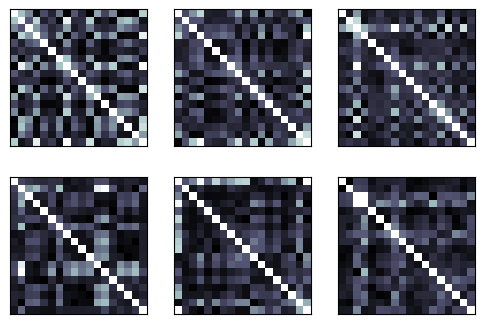

In [487]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(rsr.calc_rdm(fmri_data))
fig.savefig('temp_rdm.png', bbox_inches='tight', dpi=300)

In [488]:
obj.keys()

dict_keys(['measurements', 'descriptors', 'obs_descriptors', 'channel_descriptors', 'type', 'rsatoolbox_version'])

## subjectwise RDM

In [ ]:
rdms_expect = rsr.calc_rdm(beh_expect)
rdms_outcome = rsr.calc_rdm(beh_outcome)
rdms_fmri = rsr.calc_rdm(fmri_data)
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(fmri_data, obs_desc='pattern', method='shrinkage_eye')
rdm_fmri_maha_shrink = rsatoolbox.rdm.calc_rdm(fmri_data, descriptor='pattern', method='mahalanobis', noise=noise_prec_shrink)

rsatoolbox.vis.show_rdm(rdms_expect)
rsatoolbox.vis.show_rdm(rdms_outcome)
rsatoolbox.vis.show_rdm(rdms_fmri)
rsatoolbox.vis.show_rdm(rdm_fmri_maha_shrink)

## categorical RDM

### 1) model_cuestim

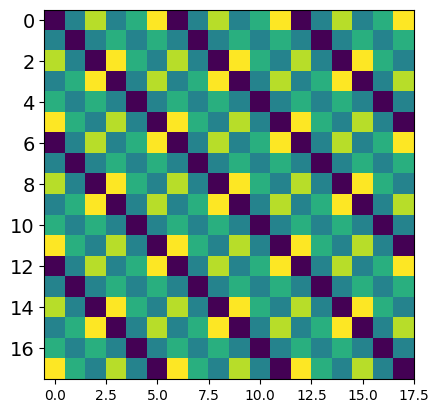

In [629]:
import numpy as np

# Generate the meshgrid
c, t, s = np.meshgrid(np.arange(0,2), np.arange(-1,2), np.arange(-1, 2))

s_2d = s.reshape(-1, 1)
c_2d = c.reshape(-1, 1)
t_2d = t.reshape(-1, 1)

xyz_cue = np.hstack((s_2d, c_2d)) # ,t_2d))
# plt.imshow(xyz_cue)

model_features = rsatoolbox.data.Dataset(np.array(xyz_cue))
model_cuestim = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_cuestim = squareform(pdist(xyz_cue))
plt.imshow(squareform(pdist(xyz_cue)))



### ver 2)  not sure if we should include this

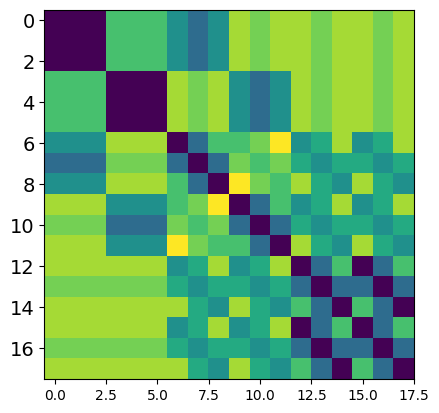

In [630]:

stim = np.array([1, 0, -1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

cst = np.vstack((c,s,t)).T
plt.imshow(cst)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(cst[:6,], c1), c1.T),
    np.dot(np.dot(cst[6:12,], c2), c2.T),
    np.dot(np.dot(cst[12:,], c3), c3.T)], axis=0)
plt.imshow(xy)
rdm = squareform(pdist(xy))
plt.imshow(rdm)


### ver 3) model_orthogonal

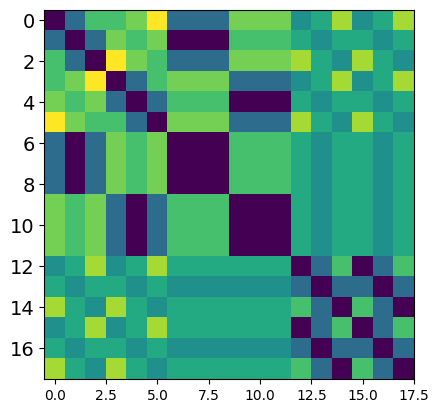

In [631]:

stim = np.array([1, 0, -1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(cst)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c1), c1.T),
    np.dot(np.dot(tcs[6:12,], c2), c2.T),
    np.dot(np.dot(tcs[12:,], c3), c3.T)], axis=0)

xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c3), c3.T),
    np.dot(np.dot(tcs[6:12,], c2), c2.T),
    np.dot(np.dot(tcs[12:,], c1), c1.T)], axis=0)


plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_orthogonal = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_orthogonal = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### model_stimtask

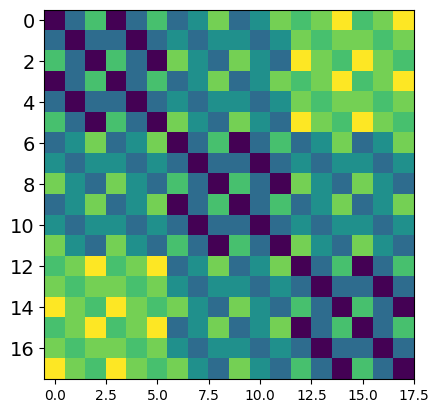

In [632]:

stim = np.array([1,2,3])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c1), c1.T),
    np.dot(np.dot(tcs[6:12,], c1), c1.T),
    np.dot(np.dot(tcs[12:,], c1), c1.T)], axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_stimtask = rsatoolbox.rdm.calc_rdm(model_features)


# rdm_stimtask = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### 4) model_cue

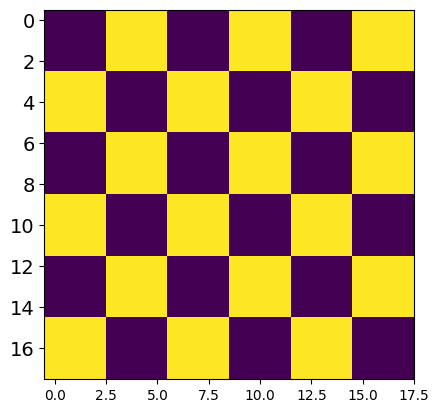

In [633]:

stim = np.array([1, 0, -1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c4), c4.T),
    np.dot(np.dot(tcs[6:12,], c4), c4.T),
    np.dot(np.dot(tcs[12:,], c4), c4.T)], axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_cue = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_cue = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


In [658]:
tcs

array([[ 1,  1,  1],
       [ 1,  1,  2],
       [ 1,  1,  3],
       [ 1, -1,  1],
       [ 1, -1,  2],
       [ 1, -1,  3],
       [ 0,  1,  1],
       [ 0,  1,  2],
       [ 0,  1,  3],
       [ 0, -1,  1],
       [ 0, -1,  2],
       [ 0, -1,  3],
       [-1,  1,  1],
       [-1,  1,  2],
       [-1,  1,  3],
       [-1, -1,  1],
       [-1, -1,  2],
       [-1, -1,  3]])

### model_stim

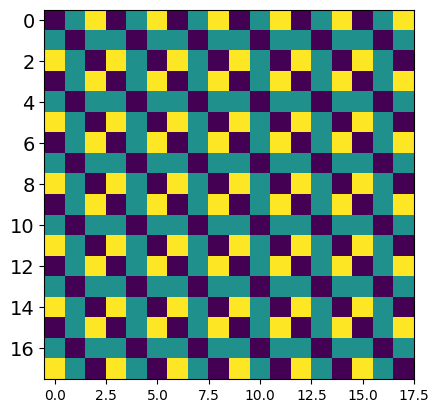

In [660]:

stim = np.array([1,2,3])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
c5 = np.array([[0,0,0],
              [0,0,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c5),np.eye(3)),
    np.dot(np.dot(tcs[6:12,], c5), np.eye(3)),
    np.dot(np.dot(tcs[12:,], c5), np.eye(3))], axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_stim = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_cue = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### grid model_grid

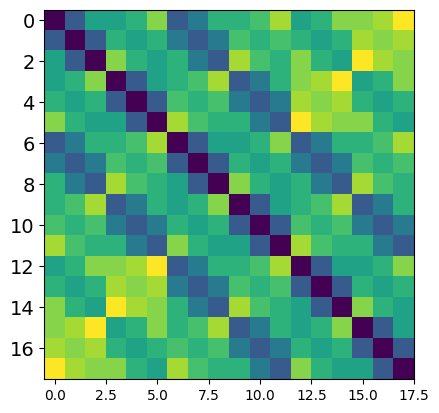

In [634]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)

model_features = rsatoolbox.data.Dataset(np.array(tcs))
model_grid = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_grid = squareform(pdist(tcs))
plt.imshow(squareform(pdist(tcs)))


### rotation grid

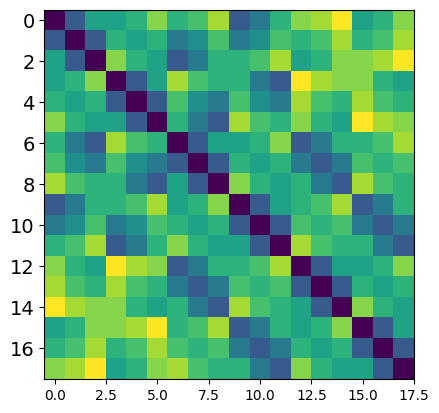

In [635]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
c5 = np.array([[0,0,0],
              [0,0,0],
              [0,0,1]])
rot = np.array([[1,0,0],
                [0, np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))],
                [0, -np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

xy = np.concatenate([
    np.dot(tcs[:6,], rot),
    tcs[6:12,],
    tcs[12:,]],
    axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_rotationgrid = rsatoolbox.rdm.calc_rdm(model_features)

# rdm = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### diagonal

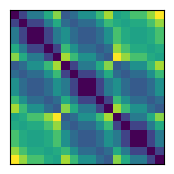

In [636]:

stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
# plt.imshow(tcs)
P = np.array([[1,0],[0, np.cos(np.deg2rad(45))],[0, np.sin(np.deg2rad(45))]])
xy = np.dot(tcs, P)
# plt.imshow(xy)
model_features = rsatoolbox.data.Dataset(np.array(xy))
model_diagonal = rsatoolbox.rdm.calc_rdm(model_features)

rsatoolbox.vis.rdm_plot.show_rdm(model_diagonal)

# rdm_diagonal = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### model_parallel: higher cues in both context

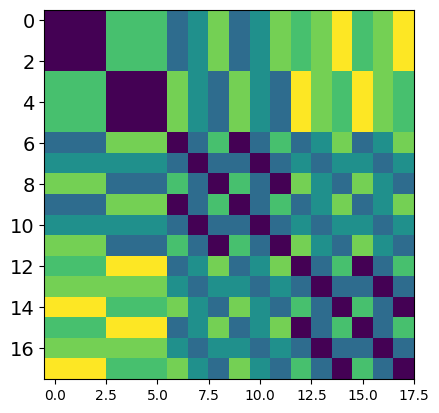

In [664]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(tcs))
# plt.imshow(rdm)


c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
c5 = np.array([[0,0,0],
              [0,0,0],
              [0,0,1]])
rot = np.array([[1,0,0],
                [0, np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))],
                [0, -np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])
result = np.dot(np.dot(tcs[:6,], c2), rot)
xy = np.concatenate([
    result,
    np.dot(tcs[6:12,], c1),
    np.dot(tcs[12:,], c2)], axis=0)

# xy = np.dot(np.dot(tcs, rot), rot.T)
# plt.imshow(xy)

model_feaures = rsatoolbox.data.Dataset(np.array(xy))
model_parallel = rsatoolbox.rdm.calc_rdm(model_feaures)

# rdm_parallel = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### model_parallel: higher stim.. in both contexts

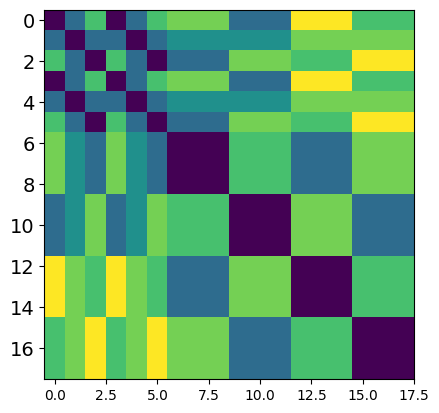

In [665]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(tcs))
# plt.imshow(rdm)


c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
c5 = np.array([[0,0,0],
              [0,0,0],
              [0,0,1]])
rot = np.array([[1,0,0],
                [0, np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))],
                [0, -np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])
result = np.dot(np.dot(tcs[:6,], c1), rot)
xy = np.concatenate([
    result,
    np.dot(tcs[6:12,], c2),
    np.dot(tcs[12:,], c2)], axis=0)

# xy = np.dot(np.dot(tcs, rot), rot.T)
# plt.imshow(xy)

model_feaures = rsatoolbox.data.Dataset(np.array(xy))
model_parallel_DEP = rsatoolbox.rdm.calc_rdm(model_feaures)

# rdm_parallel = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


In [ ]:
# now create a  dataset object
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_' + str(x) for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
#obs_des = {'conds': np.array(['cond_' + str(x) for x in np.arange(1,nCond+1)])} # indices from 1
#chn_des = {'conds': np.array(['voxel' + str(x) for x in np.arange(1,nVox+1)])} # indices from 1
data = rsd.Dataset(measurements=measurements,
                           descriptors=des,
                           obs_descriptors=obs_des,
                           channel_descriptors=chn_des)
print(data)

# RDM compare
https://rsatoolbox.readthedocs.io/en/stable/comparing.html
https://rsatoolbox.readthedocs.io/en/latest/demo_bootstrap.html#Exercise-1:-Data-and-RDM-handling

In [638]:
models = rsatoolbox.rdm.concat([
    # model_cuestim,
    model_orthogonal,
    # model_stimtask,
    model_cue,
    model_grid,
    model_rotationgrid,
    model_diagonal,
    model_parallel])
model = rsatoolbox.model.ModelWeighted('test', models)

data_rdms = rsatoolbox.rdm.calc_rdm(fmri_data)
theta = model.fit(data_rdms, method = 'cosine')
theta

array([ 0.84934847,  0.01876429,  0.0929342 ,  0.51109563, -0.03796888,
        0.0834142 ])

In [590]:
rdm_orthogonal = rsatoolbox.model.ModelFixed('orthogonal', model_orthogonal)
rdm_cue = rsatoolbox.model.ModelFixed('cue', model_cue)
rdm_grid = rsatoolbox.model.ModelFixed('grid', model_grid)
rdm_rotationgrid = rsatoolbox.model.ModelFixed('rotationgrid', model_rotationgrid)
rdm_diagonal = rsatoolbox.model.ModelFixed('diagonal', model_diagonal)
rdm_parallel = rsatoolbox.model.ModelFixed('parallel', model_parallel)


In [628]:
model_rdms = []
model_rdms = rdm_orthogonal
model_rdms.append(rdm_cue)
model_rdms.append(rdm_grid)
model_rdms.append(rdm_rotationgrid)
model_rdms.append(rdm_diagonal)
model_rdms.append(rdm_parallel)
model_rdms.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
model_rdms.pattern_descriptors['cond_names'] = expect_df.condition

AttributeError: 'ModelFixed' object has no attribute 'append'

In [607]:
rdm_model = np.vstack([model_orthogonal.dissimilarities[0],
                       model_cue.dissimilarities[0],
                       model_grid.dissimilarities[0],
                       model_rotationgrid.dissimilarities[0],
                       model_diagonal.dissimilarities[0],
                       model_parallel.dissimilarities[0]])

In [ ]:
models = []
model_names = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

(<Figure size 600x400 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493ab2610>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493a7a0a0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493aab2b0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493acebb0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493a2f940>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f84939fe6a0>}}))

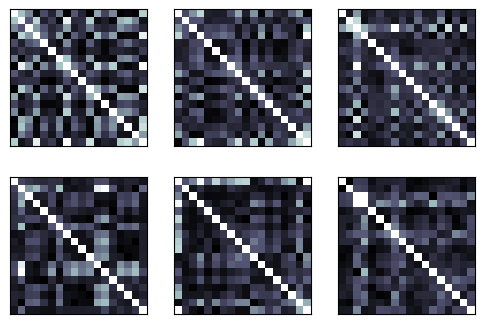

In [265]:
rsatoolbox.vis.show_rdm(data_rdms)

(<Figure size 600x400 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'orthogonal'}>,
         <AxesSubplot:title={'center':'cue'}>,
         <AxesSubplot:title={'center':'grid'}>],
        [<AxesSubplot:title={'center':'rotationgrid'}>,
         <AxesSubplot:title={'center':'diagonal'}>,
         <AxesSubplot:title={'center':'parallel'}>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:title={'center':'orthogonal'}>: {'image': <matplotlib.image.AxesImage at 0x7f8467fb2310>},
              <AxesSubplot:title={'center':'cue'}>: {'image': <matplotlib.image.AxesImage at 0x7f8467f49760>},
              <AxesSubplot:title={'center':'grid'}>: {'image': <matplotlib.image.AxesImage at 0x7f8467f7da90>},
              <AxesSubplot:title={'center':'rotationgrid'}>: {'image': <matplotlib.image.AxesImage at 0x7f8467fb2af0>},
              <AxesSubplot:title={'center':'diagonal'}>: {'image': <matplotlib.image.AxesImage at 0x7f8467d38ca0>},
              <AxesSubplot:title={'center

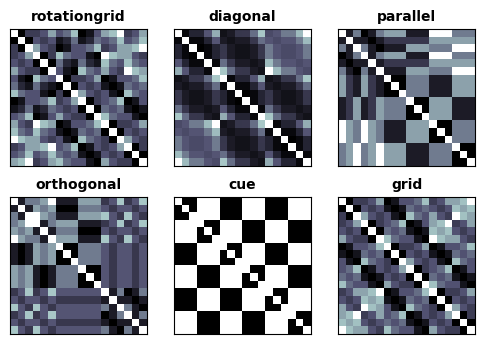

In [639]:
# combine multiple model RDMS
model_rdms = []
model_rdms = model_orthogonal
model_rdms.append(model_cue)
model_rdms.append(model_grid)
model_rdms.append(model_rotationgrid)
model_rdms.append(model_diagonal)
model_rdms.append(model_parallel)
model_rdms.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
model_rdms.pattern_descriptors['cond_names'] = expect_df.condition

# plot
rsatoolbox.vis.show_rdm(model_rdms, 
                        rdm_descriptor='model_names')
                        #, pattern_descriptor = 'cond_names')

In [640]:
r = []
for mod in model_rdms:
    r.append(rsatoolbox.rdm.compare(model_rdms, data_rdms, method='cosine'))


In [669]:
r[0].shape

(6, 6)

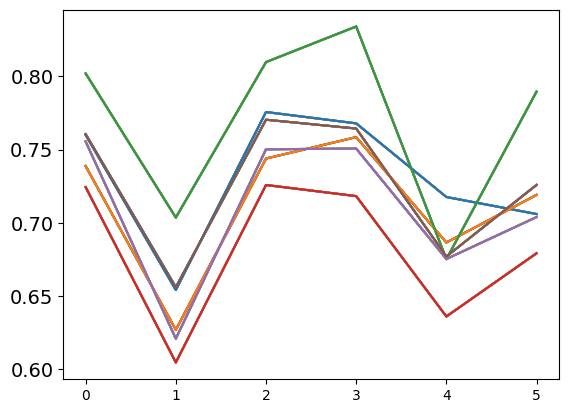

In [641]:
r = []
for mod in model_rdms:
    r.append(rsatoolbox.rdm.compare(model_rdms, data_rdms, method='cosine'))

model_name= ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
for i, r_ in enumerate(r):
    plt.plot( r_.squeeze(), label=model_name[i])
            #  model_rdms[i].rdm_descriptors['model_names'][0])


In [395]:
model_rdms.to_dict().keys()

dict_keys(['dissimilarities', 'descriptors', 'rdm_descriptors', 'pattern_descriptors', 'dissimilarity_measure'])

In [218]:
train_set, test_set, ceil_set = rsatoolbox.inference.sets_leave_one_out_rdm(data_rdms)
results_cv = rsatoolbox.inference.crossval(model, data_rdms, train_set, test_set, ceil_set=ceil_set, method='corr')

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/vis/model_plot.py:232: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'
/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/vis/model_plot.py:238: UserWarning: errorbars deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('errorbars deactivated as crossvalidation does not'


(<Figure size 1250x1000 with 1 Axes>, <Axes:>, None)

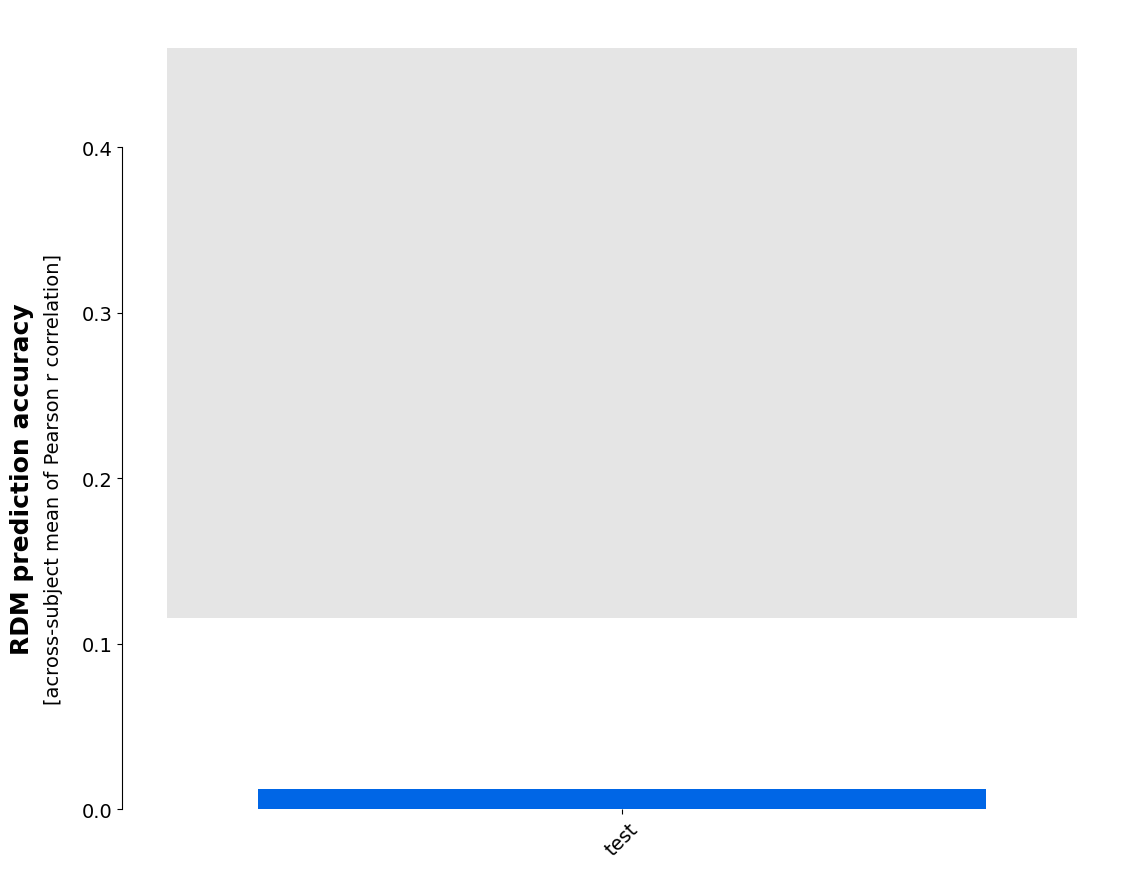

In [220]:
rsatoolbox.vis.plot_model_comparison(results_cv)

# copy cat

In [642]:
rdm_model = np.vstack([model_orthogonal.dissimilarities[0],
                       model_cue.dissimilarities[0],
                       model_grid.dissimilarities[0],
                       model_rotationgrid.dissimilarities[0],
                       model_diagonal.dissimilarities[0],
                       model_parallel.dissimilarities[0]])

In [643]:
# rdm_model
model_rdms_copycat = rsatoolbox.rdm.RDMs(rdm_model,
                                         rdm_descriptors={
    'model_names':['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']},
    pattern_descriptors = {'cond_names':expect_df.condition},
                            dissimilarity_measure='Euclidean'
                           )



(<Figure size 600x400 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'orthogonal'}>,
         <AxesSubplot:title={'center':'cue'}>,
         <AxesSubplot:title={'center':'grid'}>],
        [<AxesSubplot:title={'center':'rotationgrid'}>,
         <AxesSubplot:title={'center':'diagonal'}>,
         <AxesSubplot:title={'center':'parallel'}>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:title={'center':'orthogonal'}>: {'image': <matplotlib.image.AxesImage at 0x7f846ac36b50>},
              <AxesSubplot:title={'center':'cue'}>: {'image': <matplotlib.image.AxesImage at 0x7f846ac09280>},
              <AxesSubplot:title={'center':'grid'}>: {'image': <matplotlib.image.AxesImage at 0x7f846ac3e100>},
              <AxesSubplot:title={'center':'rotationgrid'}>: {'image': <matplotlib.image.AxesImage at 0x7f846ad832e0>},
              <AxesSubplot:title={'center':'diagonal'}>: {'image': <matplotlib.image.AxesImage at 0x7f846ab67700>},
              <AxesSubplot:title={'center

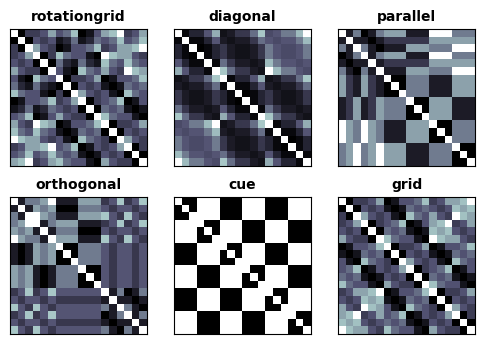

In [666]:
rsatoolbox.vis.show_rdm(model_rdms_copycat, 
                        rdm_descriptor='model_names')

In [644]:
models = []
model_names = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
for i_model in np.unique(model_names):
    rdm_m = model_rdms_copycat.subset('model_names', i_model)
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
cue
diagonal
grid
orthogonal
parallel
rotationgrid


(<Figure size 1250x1000 with 2 Axes>, <Axes:>, <Axes:>)

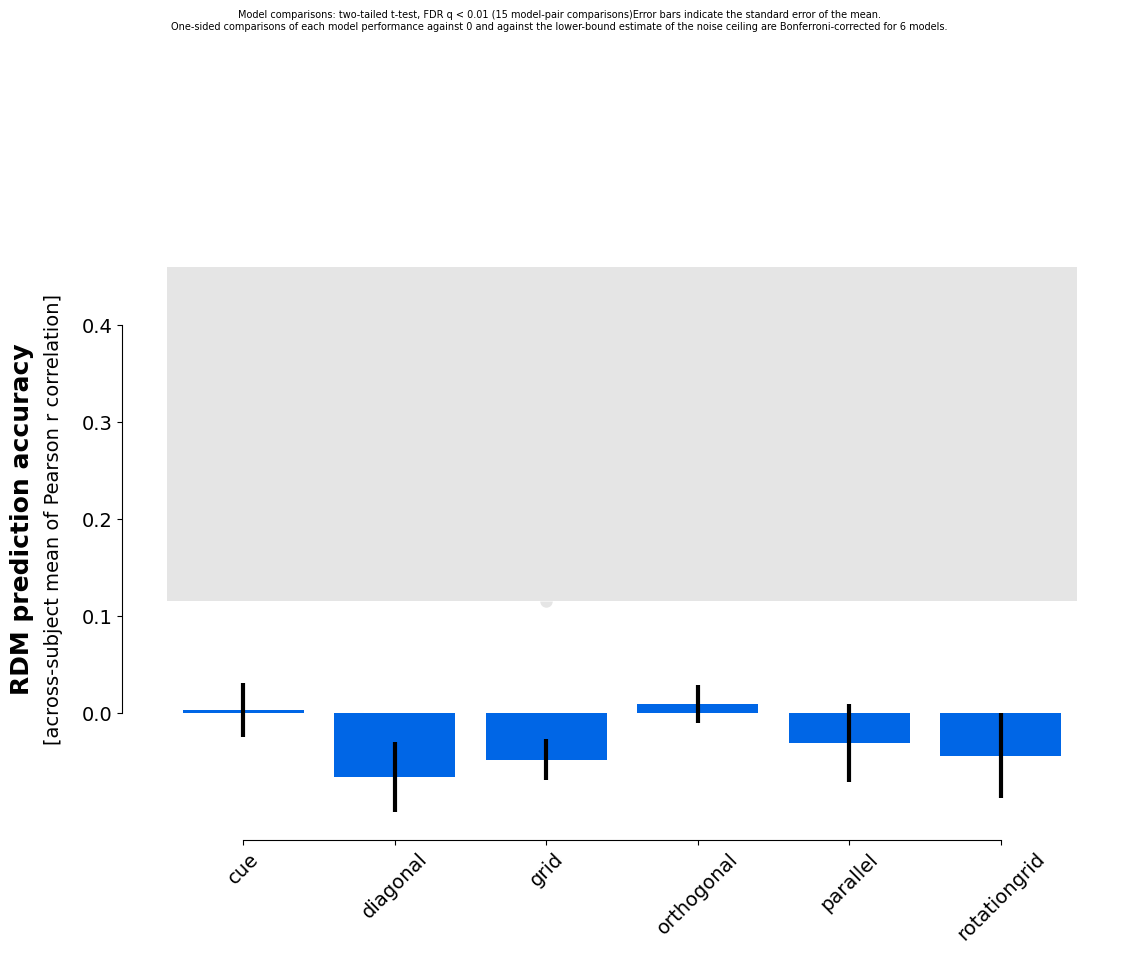

In [645]:
results_1 = rsatoolbox.inference.eval_fixed(models, data_rdms, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

In [646]:
print(results_1)

Results for running fixed evaluation for corr on 6 models:

Model        |   Eval ± SEM   | p (against 0) | p (against NC) |
----------------------------------------------------------------
cue          |  0.003 ± 0.028 |        0.460  |         0.010  |
diagonal     | -0.066 ± 0.036 |        0.938  |         0.004  |
grid         | -0.048 ± 0.021 |        0.965  |       < 0.001  |
orthogonal   |  0.009 ± 0.020 |        0.325  |         0.003  |
parallel     | -0.031 ± 0.040 |        0.761  |         0.015  |
rotationgrid | -0.044 ± 0.044 |        0.821  |         0.015  |

p-values are based on uncorrected t-tests


100%|██████████| 1000/1000 [00:03<00:00, 316.95it/s]


(<Figure size 1250x1000 with 2 Axes>, <Axes:>, <Axes:>)

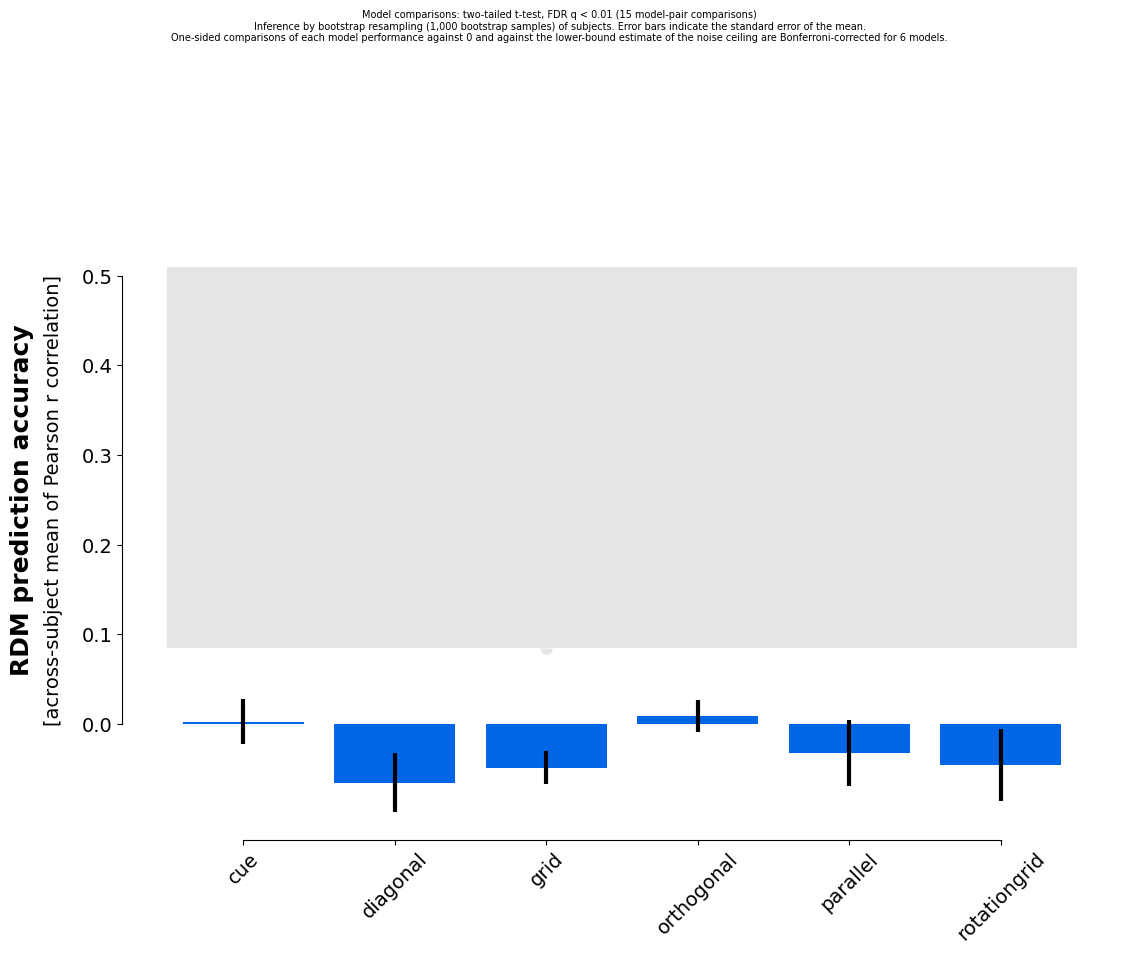

In [647]:
results_2a = rsatoolbox.inference.eval_bootstrap_rdm(models, data_rdms, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2a)

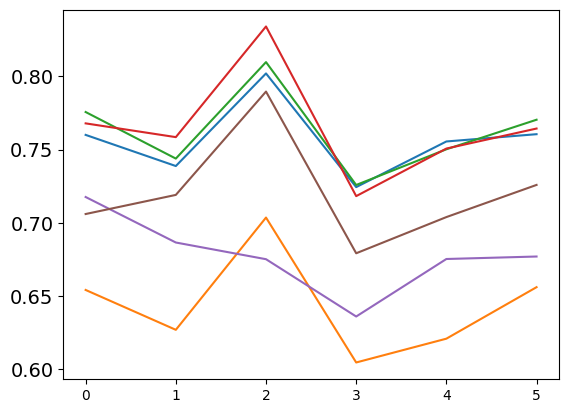

In [670]:
r = []
for mod in model_rdms_copycat:
    r.append(rsatoolbox.rdm.compare(mod, data_rdms, method='cosine'))

model_name= ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
for i, r_ in enumerate(r):
    plt.plot( r_.squeeze(), label=model_name[i])
            #  model_rdms[i].rdm_descriptors['model_names'][0])


In [671]:
type(r)

list